## Diffusion Model From Scratch
### 12/10/22
### [Link](https://www.youtube.com/watch?v=a4Yfz2FxXiY&t=227s)

In [44]:
import numpy as np
import math
import torch
import torchvision
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

* Step 01. Import dataset

In [8]:
def show_images(dataset, num_samples = 20, cols = 4):
    """
    Plots some samples from the dataset
    """
    plt.figure(figsize = (15,15))
    
    for idx, img in enumerate(data):
        if idx == num_samples:
            break
        plt.subplot(int(num_samples/cols + 1), cols, idx + 1)
        plt.imshow(img[0])

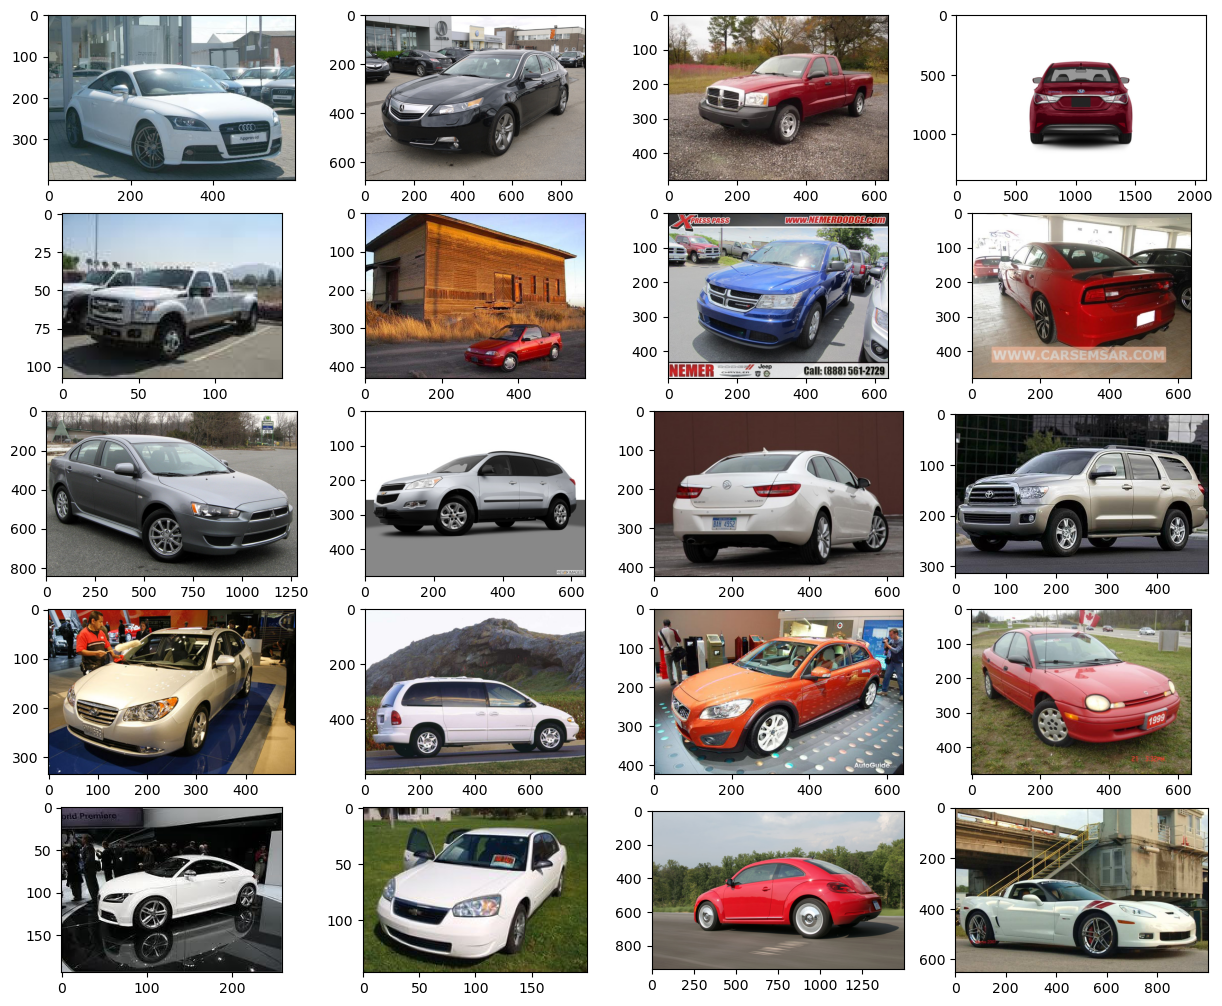

In [9]:
data = torchvision.datasets.StanfordCars(root = '.', download = True)
show_images(data)

* Step 02. Noise Scheduler

In [11]:
def linear_beta_schedule(timesteps, start = 1e-4, end = 2e-2):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """
    Returns a specific index t of a passed list of values vals while
    considering the 'batch dimension'
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    
    return out.reshape(batch_size, *((1,) * (len(x_shape) -1))).to(t.device)

def forward_diffusion_sample(x_0, t, device = 'cpu'):
    """
    x_0 -> Initial image
    Takes an image and a timestep as input and returns
    the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    ## mean + variance
    res1 = sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)
    return res1, noise.to(device)

* **res1** calculation in *forward_diffusion_sample*:
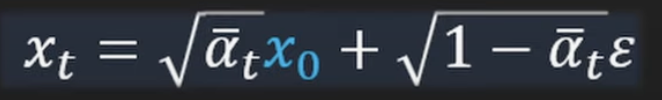

* **Alphas** calculation:
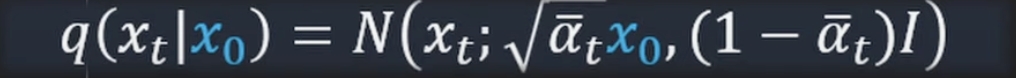

* T = 300 results will be run!!

In [12]:
## Define beta schedule
T = 200
betas = linear_beta_schedule(timesteps = T)

### Pre-calculate different terms for closed form
alphas = 1.0 - betas

alphas_cumprod = torch.cumprod(alphas, axis = 0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value = 1.0)

sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

* Step 03. Test the dataset & finalize noise scheduler

In [22]:
IMG_SIZE = 64
BATCH_SIZE = 128

def load_transformed_dataset():
    data_transforms = [transforms.Resize((IMG_SIZE, IMG_SIZE)),
                     transforms.RandomHorizontalFlip(),
                     transforms.ToTensor(),                   ## Scales data into [0, 1]
                     transforms.Lambda(lambda t: (t * 2) -1)  ## Scale between [-1, 1]
                     ]
    data_transform = transforms.Compose(data_transforms)
    
    train = torchvision.datasets.StanfordCars(root = '.', download = True, transform = data_transform)
    test = torchvision.datasets.StanfordCars(root = '.', download = True, transform = data_transform, split = 'test')
    
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  ### CHW to HWC
        transforms.Lambda(lambda t: t * 255.0),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])
    
    ## Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))

In [23]:
data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

Using downloaded and verified file: stanford_cars/car_devkit.tgz
Extracting stanford_cars/car_devkit.tgz to stanford_cars


  0%|          | 0/977350468 [00:00<?, ?it/s]

Extracting stanford_cars/cars_test.tgz to stanford_cars


  0%|          | 0/185758 [00:00<?, ?it/s]

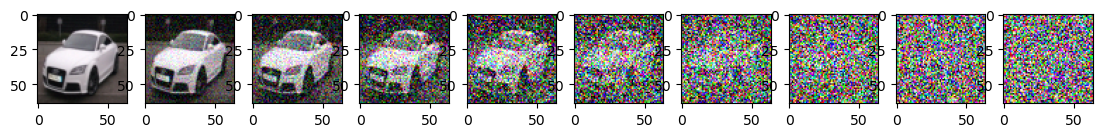

In [26]:
## Simulate forward diffusion (noise scheduler)
image = next(iter(dataloader))[0]

plt.figure(figsize = (15, 15))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, int(num_images + 1), int((idx/stepsize) + 1))
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

* Step 04. Neural network structure
* **Model structure**
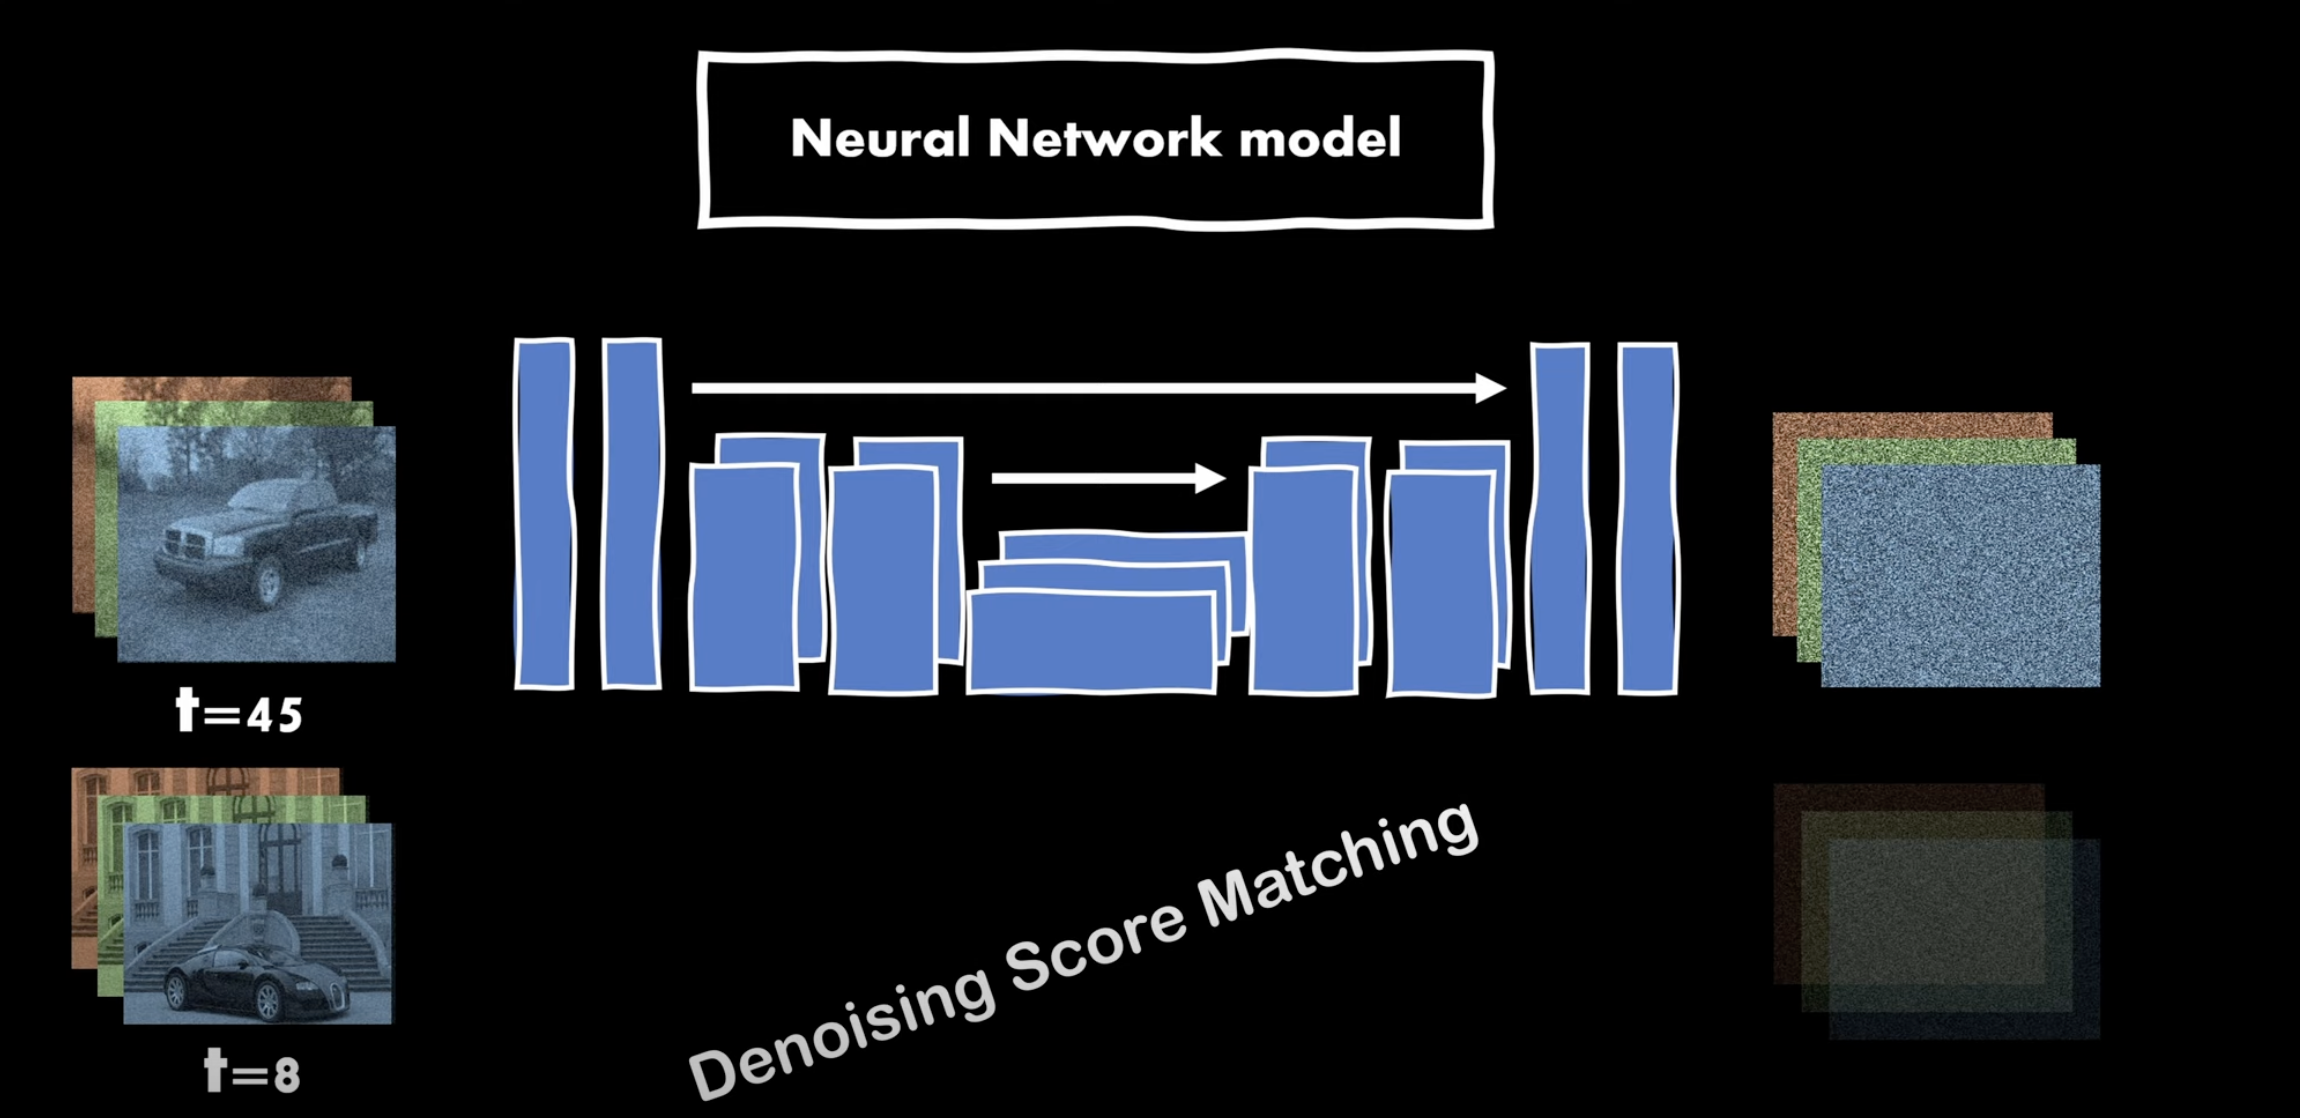

* **Bacpropagation**
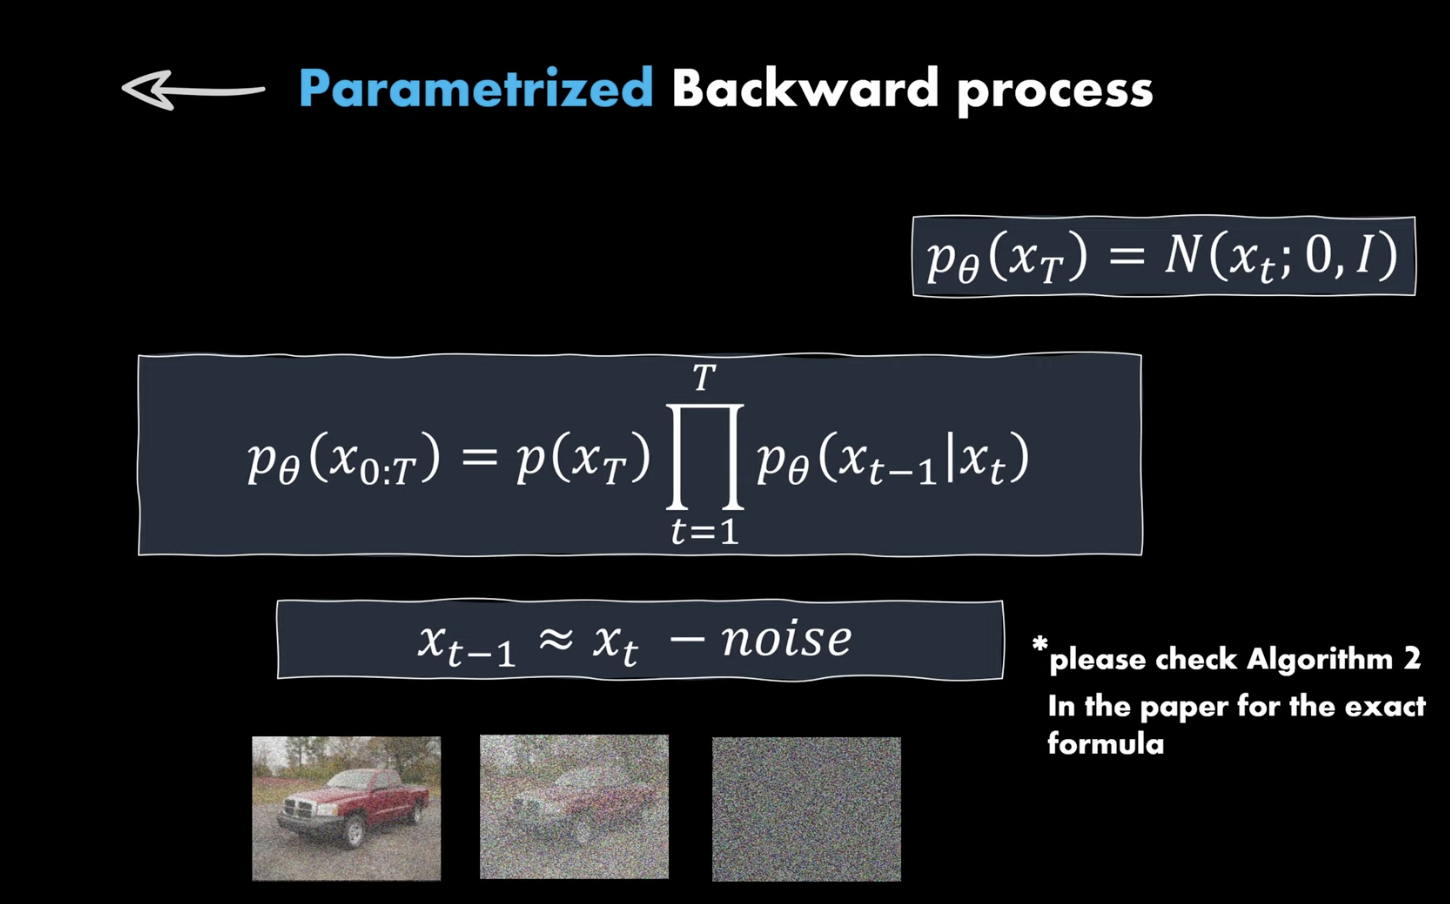

* Step 05. Timestep Encoding

In [32]:
### U-Net implementation
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emd_dim, up = False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emd_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding = 1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding = 1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding = 1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x, t):
        ## First convolution
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None, ) * 2]
        ## Add time channel
        h += time_emb
        
        ## Second convolution
        h = self.bnorm2(self.relu(self.conv2(h)))
        
        ## Downsample OR Upsample
        return self.transform(h)

In [36]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(1e4) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device = device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim = -1)
        ## DOUBLE CHECK ORDERING HERE
        return embeddings

* **U-net**:
- [Link](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
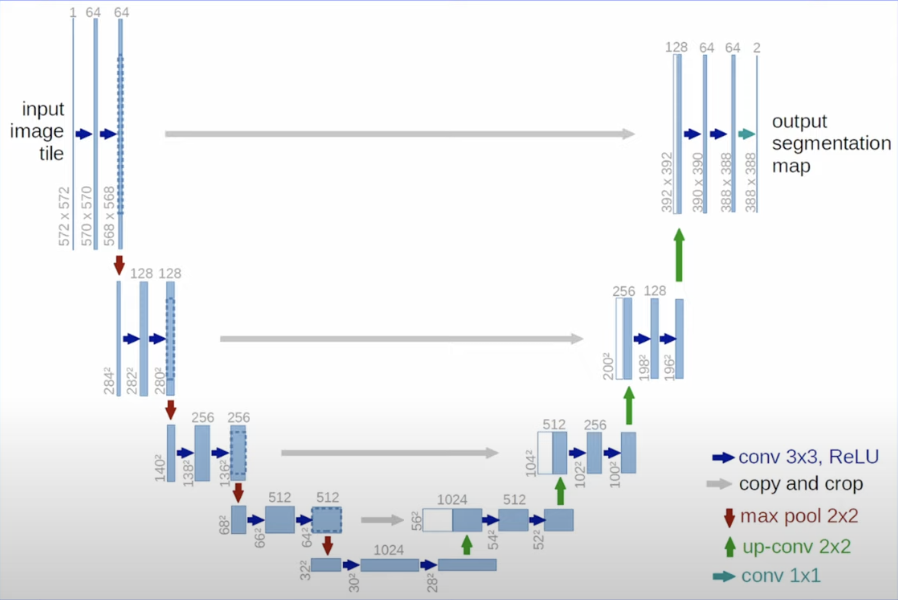

In [39]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 512, 1024)
        up_channels = (1024, 512, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        ## Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        ## Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 
                              3, padding = 1)
        ## Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1],
                                         time_emb_dim) for i in range(len(down_channels) - 1)])
        ## Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1],
                                       time_emb_dim, up = True) for i in range(len(up_channels) - 1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)
    
    def forward(self, x, timestep):
        ## Embedding time
        t = self.time_mlp(timestep)
        ## Initial conv
        x = self.conv0(x)
        ## Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            ## Add residual x as additional channels
            x = torch.cat((x, residual_x), dim = 1)
            x = up(x, t)
        return self.output(x)

In [40]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  56487395


In [41]:
model

SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=512, bias=True)
      (conv1): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

* ***The loss function:***
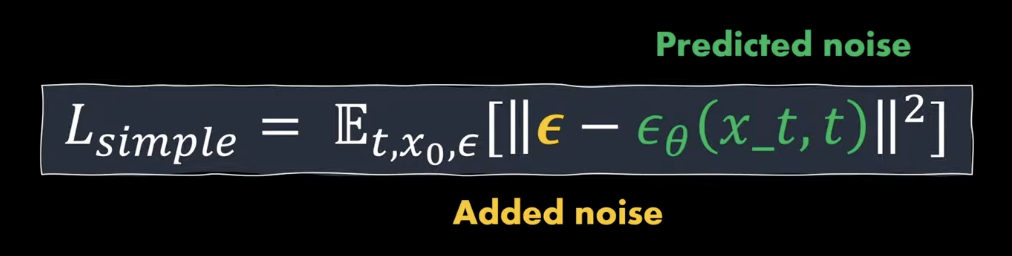

In [42]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)  ## L2 loss may be selected

* Step 06. Sampling

In [52]:
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and
    returns the denoised image.
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    ## Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise
    
def sample_plot_image():
    ## Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device = device)
    plt.figure(figsize = (15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)
    
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device = device, dtype = torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize) + 1)
            show_tensor_image(img.detach().cpu())
        plt.show()

In [53]:
# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
              
else:
    mps_device = torch.device("mps")

    # Create a Tensor directly on the mps device
    x = torch.ones(5, device=mps_device)
    # or x = torch.ones(5, device="mps")

    # Any operation happens on the GPU
    y = x * 2

    print(f"working device: {y.device}") # this should be mps
    print("experiment successful")

working device: mps:0
experiment successful


working device: mps:0
Epoch 0 | step 000 | Loss: 0.6774822473526001


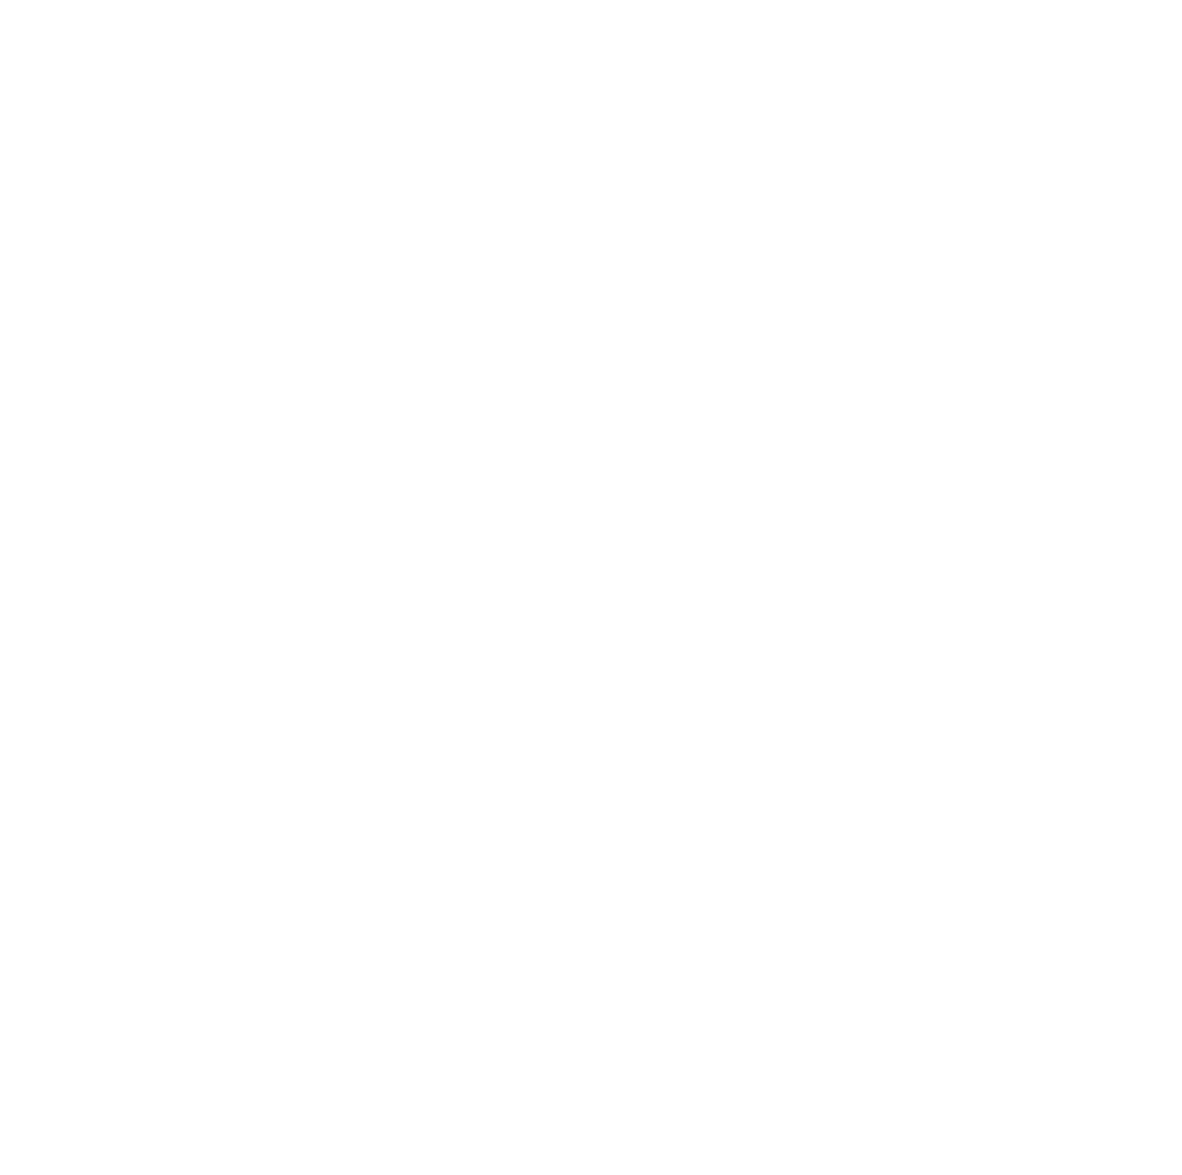

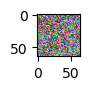

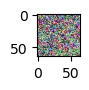

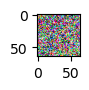

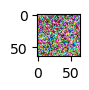

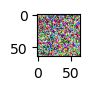

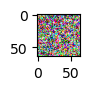

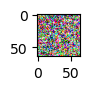

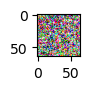

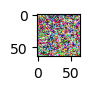

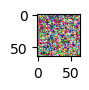

Epoch 5 | step 000 | Loss: 0.1850161850452423


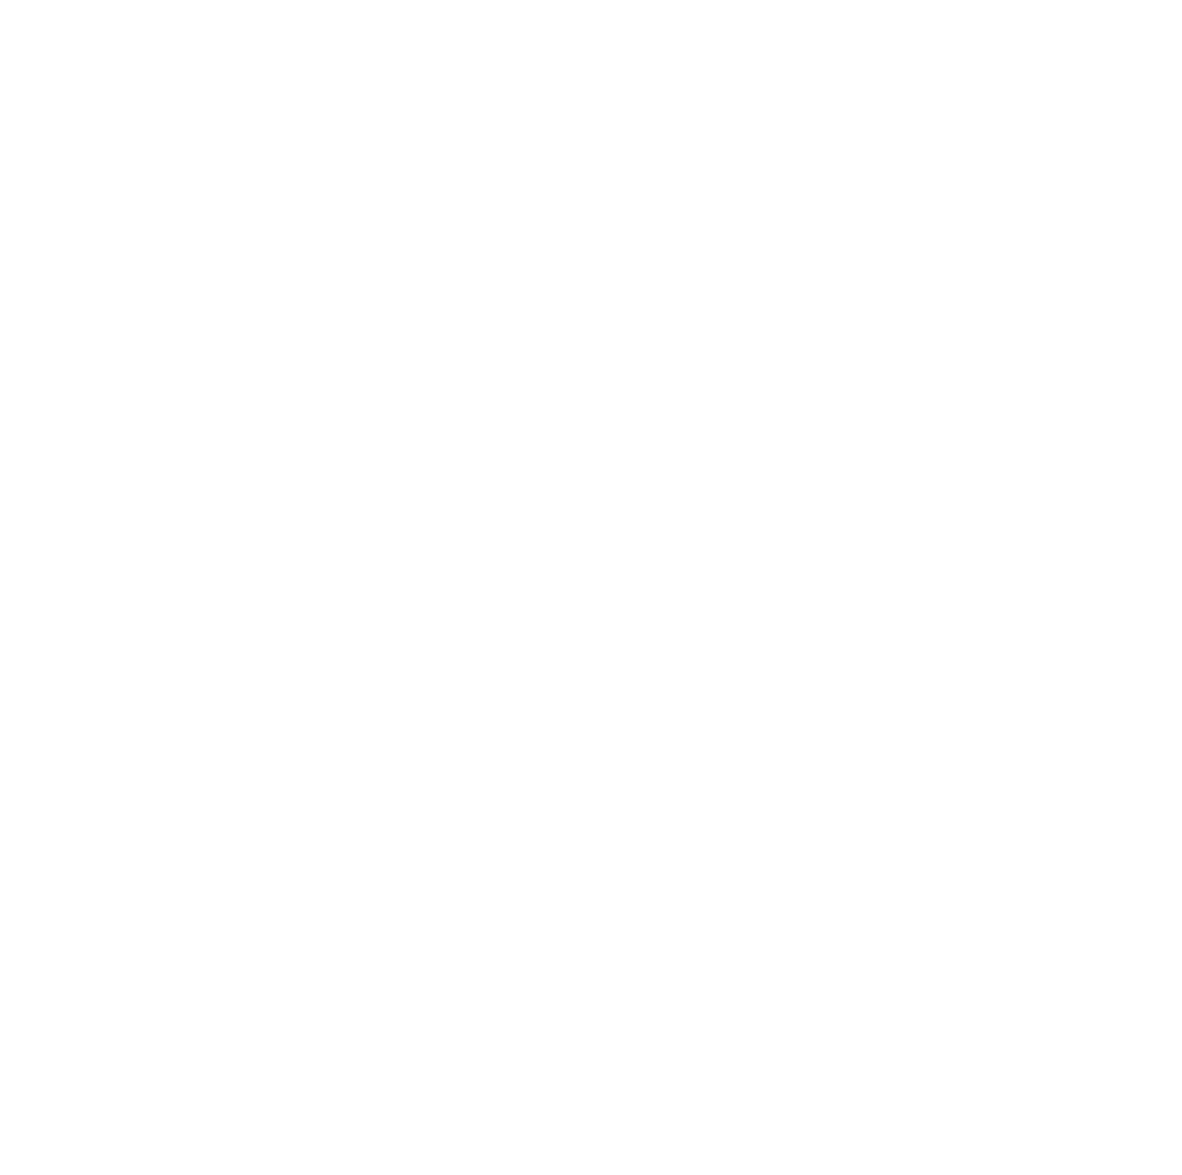

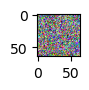

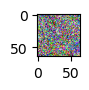

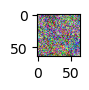

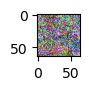

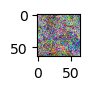

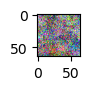

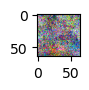

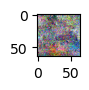

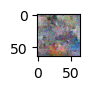

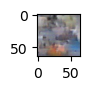

KeyboardInterrupt: 

In [54]:
device = torch.device('mps')
print(f"working device: {y.device}")
model.to(device)
optimizer = Adam(model.parameters(), lr = 1e-3)
epochs = 100 ## More epochs can be tried, 100 is initial value
## 1000 epoch may be better
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        
        t = torch.randint(0, T, (BATCH_SIZE,), device = device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()
        
        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} | Loss: {loss.item()}")
            sample_plot_image()